In [ ]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns
import lsqfit
import tqdm

In [ ]:
from b2heavy                             import FnalHISQMetadata
from b2heavy.TwoPointFunctions.types2pts import CorrelatorIO, Correlator, plot_effective_coeffs
from b2heavy.TwoPointFunctions.fitter    import StagFitter

In [ ]:
BINSIZE = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

In [ ]:
ENSEMBLE = 'Coarse-Phys'
MOMENTUM = '300'
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
SMLIST   = ['1S-1S','d-d','d-1S']
trange = (5,19)

In [ ]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

# Spectrum

2.5e+19
1.2e+19
1.8e+18
4.9e+18
4.5e+17
8.6e+17
7.4e+06
3.8e+04
3.8e+03
5.2e+02


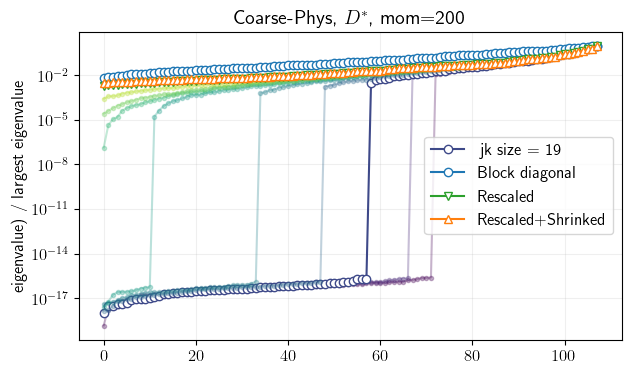

In [342]:
f, ax = plt.subplots(figsize=(7, 4))
jks = [1,6,8,9,10,13,16,19,23,26]

cmap = plt.get_cmap('viridis',len(jks))

# SIMPLE JACKKNIFE
for i,jk in enumerate(reversed(jks)):
    io = CorrelatorIO(ENSEMBLE,'Dst',MOMENTUM,PathToDataDir=DATA_DIR)
    stag = Correlator(io,smearing=['1S-1S','d-d','d-1S'],jkBin=jk)
    x,y = stag.format(trange=(5,22),flatten=True)    
    corr = gv.evalcorr(y)

    eval, evec = np.linalg.eigh(corr)

    condn = f'{np.linalg.cond(corr):.1e}'
    print(condn)

    eval,evec = np.linalg.eigh(corr)

    y = sorted(abs(eval))/max(eval)

    label = f'jk size = {jk}'

    if jk==BINSIZE[ENSEMBLE]:
        ax.plot(np.arange(len(eval)), y, marker='o', mfc='w', color=cmap(i), label=label)
    else:
        ax.plot(np.arange(len(eval)), y, marker='.', color=cmap(i), alpha=0.3)

# DIAG
io = CorrelatorIO(ENSEMBLE,'Dst',MOMENTUM,PathToDataDir=DATA_DIR)
stag = Correlator(io,smearing=['1S-1S','d-d','d-1S'],jkBin=BINSIZE[ENSEMBLE])
x,y = stag.format(trange=(5,22),flatten=True, block=True)    
corr = gv.evalcorr(y)
eval,evec = np.linalg.eigh(corr)
y = sorted(abs(eval))/max(eval)
ax.plot(np.arange(len(eval)), y, marker='o', mfc='w', color='C0', label='Block diagonal')


# SCALE
io = CorrelatorIO(ENSEMBLE,'Dst',MOMENTUM,PathToDataDir=DATA_DIR)
stag = Correlator(io,smearing=['1S-1S','d-d','d-1S'],jkBin=BINSIZE[ENSEMBLE])
x,y = stag.format(trange=(5,22),flatten=True, scale=True)    
corr = gv.evalcorr(y)
eval,evec = np.linalg.eigh(corr)
y = sorted(abs(eval))/max(eval)
ax.plot(np.arange(len(eval)), y, marker='v', mfc='w', color='C2', label='Rescaled')



# SHRINKED
io = CorrelatorIO(ENSEMBLE,'Dst',MOMENTUM,PathToDataDir=DATA_DIR)
stag = Correlator(io,smearing=['1S-1S','d-d','d-1S'],jkBin=BINSIZE[ENSEMBLE])
x,y = stag.format(trange=(5,22),flatten=True, scale=True, shrink=True)    
corr = gv.evalcorr(y)
eval,evec = np.linalg.eigh(corr)
y = sorted(abs(eval))/max(eval)
ax.plot(np.arange(len(eval)), y, marker='^', mfc='w', color='C1', label='Rescaled+Shrinked')



ax.set_yscale('log')
ax.legend()
ax.set_ylabel(r'eigenvalue) / largest eigenvalue')
ax.set_title(fr'{ENSEMBLE}, $D^*$, mom={MOMENTUM}')

ax.grid(alpha=0.2)
plt.savefig('/Users/pietro/Desktop/corr_spectrum.pdf')

We can see from that that for binsize $\geq 9$ a large gap between the eigenvalues forms. It is very likely that low modes gets heavily underestimated.

We can see in fact using a bootstrap analysis, an svd cut of 0.05 is suggested.

In [ ]:
corr = Correlator(io,smearing=['1S-1S','d-d','d-1S'],jkBin=BINSIZE[ENSEMBLE])
x,ydata, ysamples = corr.format(trange=trange,flatten=True,alljk=True)   
svd = gv.dataset.svd_diagnosis(ysamples)

f, ax = plt.subplots(figsize=(7, 4))

svd.plot_ratio()
eps = svd.svdcut

print(eps)

plt.tight_layout()
plt.savefig('/Users/pietro/Desktop/svd.pdf')

# $\chi^2_\text{exp}$ for some different cases

In [363]:
ENSEMBLE = 'SuperFine'
MOMENTUM = '300'
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
SMLIST   = ['1S-1S','d-d','d-1S']

TRANGE_EFF = (24,42) 
TRANGE     = (11,42)

In [364]:
io = CorrelatorIO(ENSEMBLE,'Dst',MOMENTUM,PathToDataDir=DATA_DIR)
stag = StagFitter(io,smearing=['1S-1S','d-d','d-1S'],jkBin=BINSIZE[ENSEMBLE])

In [365]:
effm,effa = stag.meff(TRANGE_EFF,scale=True,shrink=True)
pr = stag.priors(3,Meff=effm,Aeff=effa)

/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in sqrt
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )
/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in log
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )
/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in arccosh
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )


In [366]:
fits = {}

In [367]:
# ----------- STANDARD CASES --------------
spec_list = {
    'diag':  dict(diag=True, block=False,scale=False,shrink=False,cutsvd=1e-12),
    'block': dict(diag=False,block=True, scale=False,shrink=False,cutsvd=1e-12),
    'scale+shrink': dict(diag=False,block=False,scale=True, shrink=True, cutsvd=1e-12),
    'scale+shrink+svd': dict(diag=False,block=False,scale=True, shrink=True, cutsvd=0.001),
}

for k in spec_list:
    print(k)
    fit = stag.fit(3,TRANGE,priors=pr,**spec_list[k])
    res = stag.fit_result(3,TRANGE,error=False,verbose=False,priors=fit.prior)

    fits[k] = {'fit':fit, 'res':res}

diag
block
scale+shrink
scale+shrink+svd


In [368]:
# ------------ SVD CUTS ---------------
svds = np.concatenate([
    [0.0001,0.001,0.005],np.linspace(0.01,0.1,10)],
)

for svd in svds:
    print(f'------ {svd} ------')
    fit = stag.fit(3,TRANGE, priors=pr, cutsvd=svd)
    res = stag.fit_result(3,TRANGE, error=True,verbose=False, priors=fit.prior)
    fits[f'SVD [{svd:.4f}]'] = {'fit': fit,'res': res}

------ 0.0001 ------
------ 0.001 ------
------ 0.005 ------
------ 0.01 ------
------ 0.020000000000000004 ------
------ 0.030000000000000006 ------
------ 0.04000000000000001 ------
------ 0.05000000000000001 ------
------ 0.06000000000000001 ------
------ 0.07 ------
------ 0.08 ------
------ 0.09000000000000001 ------
------ 0.1 ------


In [ ]:
# # ----------- FULL COVARIANCE ------------
# fit = stag.fit(3,TRANGE,priors=pr)
# res = stag.fit_result(3,TRANGE,verbose=False,priors=fit.prior)
# fits['full'] = {'fit': fit,'res': res}

In [369]:
Npar3 = len(np.concatenate([pr[k] for k in pr]))
Ncut = stag.Nt - (max(TRANGE)-min(TRANGE))

In [370]:
#aic = chiaug + 2k + 2Ncut

norm_tic = sum([np.exp(-(fits[k]['res']['chi2aug'] - 2*fits[k]['res']['chiexp'])/2) for k in fits])
norm_aic = sum([np.exp(-(fits[k]['res']['chi2aug'] + 2*Npar3 + 2*Ncut)/2) for k in fits])

In [371]:
df = []
for k in fits:
    e0  = fits[k]['fit'].p['E'][0]
    z1s_par = np.exp(fits[k]['fit'].p['Z_1S_Par'][0]) * np.sqrt(2 * e0)
    z1s_bot = np.exp(fits[k]['fit'].p['Z_1S_Bot'][0]) * np.sqrt(2 * e0)
    zd_par  = np.exp(fits[k]['fit'].p['Z_d_Par'][0]) * np.sqrt(2 * e0)
    zd_bot  = np.exp(fits[k]['fit'].p['Z_d_Bot'][0]) * np.sqrt(2 * e0)

    chiexp = fits[k]['res']['chiexp']
    chiaug = fits[k]['res']['chi2aug']
    chi2   = fits[k]['res']['chi2']

    wtic = np.exp(-(chiaug-2*chiexp)/2)/norm_tic
    waic = np.exp(-(chiaug+2*Ncut+2*Npar3)/2)/norm_aic

    df.append(
        {
            'k': k,
            'E0': e0,
            'z1s_par': z1s_par,
            'z1s_bot': z1s_bot,
            'zd_par':  zd_par ,
            'zd_bot':  zd_bot ,
            'chi_exp': chiexp,
            'aug/exp': chiaug/chiexp,
            'aug-2exp': chiaug-2*chiexp,
            'TIC': wtic,
            'AIC': waic,
            'p-value': fits[k]['res']['pvalue'],
            'p-standard': fits[k]['res']['p_standard'],
            # 'chi2': chi2,
            # 'chi_aug': chiaug,

        }
    )

df = pd.DataFrame(df).set_index('k').sort_index()
df

,E0,z1s_par,z1s_bot,zd_par,zd_bot,chi_exp,aug/exp,aug-2exp,TIC,AIC,p-value,p-standard
k,,,,,,,,,,,,
SVD [0.0001],0.4548(43),0.0361(35),0.0334(33),0.00184(17),0.00090(12),80.708920,99.592465,7876.582428,0.000000e+00,0.000000e+00,0.0000,1.086944e-321
SVD [0.0010],0.5709(75),0.67(17),0.62(16),0.0317(78),0.0279(74),78.371415,11.662748,757.283259,4.014430e-191,4.313785e-192,0.0000,1.219808e-52
SVD [0.0050],0.5880(40),1.126(95),1.037(84),0.0520(43),0.0480(42),73.499000,3.228490,90.292759,2.746445e-46,3.855391e-45,0.0000,2.616848e-02
SVD [0.0100],0.5898(35),1.167(76),1.075(68),0.0537(36),0.0498(35),69.086602,2.112499,7.772159,2.279772e-28,2.639180e-25,0.0000,9.815634e-01
SVD [0.0200],0.5913(35),1.198(69),1.103(62),0.0549(34),0.0511(32),62.550305,1.521031,-29.959647,3.558352e-20,2.841215e-14,0.0000,9.999999e-01
SVD [0.0300],0.5920(35),1.211(69),1.116(62),0.0554(34),0.0517(33),57.786451,1.290296,-41.011265,8.934646e-18,8.360807e-10,0.0000,1.000000e+00
SVD [0.0400],0.5925(36),1.220(71),1.124(64),0.0558(35),0.0521(33),54.279648,1.143218,-46.505826,1.393818e-16,4.348724e-07,0.0015,1.000000e+00
SVD [0.0500],0.5928(37),1.225(72),1.129(66),0.0560(36),0.0523(34),51.495373,1.037703,-49.553818,6.398368e-16,3.231620e-05,0.0105,1.000000e+00
SVD [0.0600],0.5930(38),1.229(72),1.133(66),0.0562(36),0.0525(34),49.265994,0.960503,-51.211863,1.465916e-15,6.881251e-04,0.0379,1.000000e+00


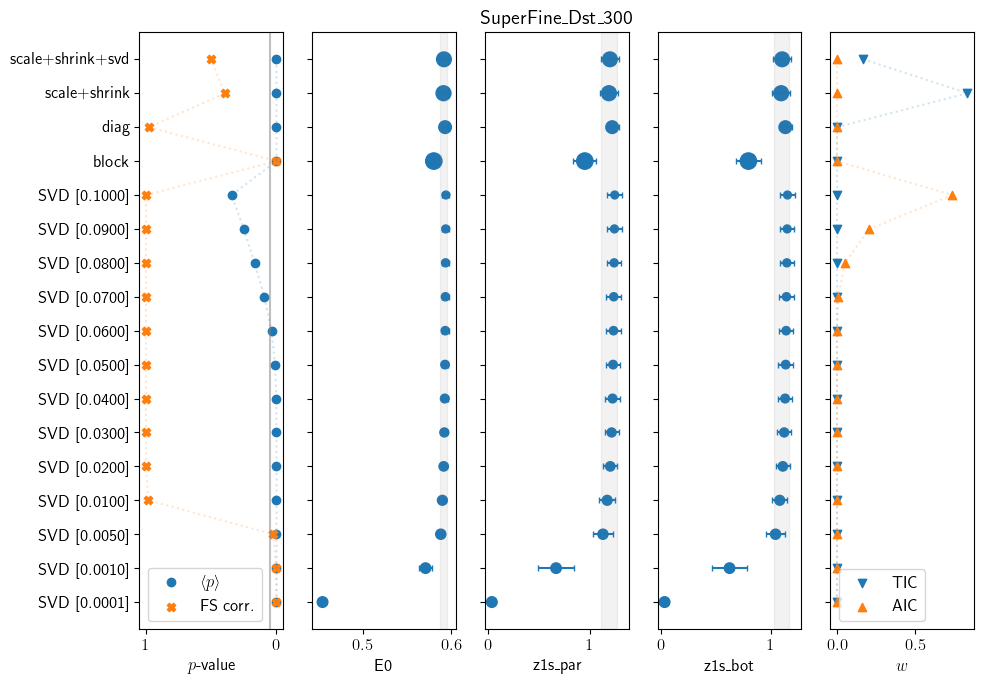

In [372]:
OBS = ['E0', 'z1s_par', 'z1s_bot']#, 'zd_par', 'zd_bot']


fig,ax = plt.subplots(1,len(OBS)+2 , figsize=(10,7), sharey=True)

N = df.shape[0]


# p-values
ax[0].scatter(df['p-value'],range(N),label=r'$\langle p \rangle$',marker='o')
ax[0].plot(df['p-value'],range(N),alpha=0.2,linestyle=':')
ax[0].scatter(df['p-standard'],range(N),label=r'FS corr.',marker='X')
ax[0].plot(df['p-standard'],range(N),alpha=0.2,linestyle=':')
ax[0].set_yticks(range(N),labels=df.index)
ax[0].invert_xaxis()
ax[0].legend()
ax[0].axvline(0.05,color='gray',alpha=0.5)
ax[0].set_xlabel(r'$p$-value')

# Central plot
norm_chiexp = df['chi_exp'].sum()
off = 1
for i,cx in enumerate(OBS):
    m_av = (df['TIC']*df[cx]).sum()

    obs = df[cx].values
    sz = df['chi_exp'].values/norm_chiexp * 1000
    ax[off+i].scatter(gv.mean(obs),range(N), marker='o', s=sz)
    ax[off+i].errorbar(gv.mean(obs),range(N),xerr=(gv.sdev(obs)), fmt=',',capsize=2.5)
    ax[off+i].set_xlabel(cx)
    ax[off+i].axvspan(m_av.mean-m_av.sdev,m_av.mean+m_av.sdev,color='gray',alpha=0.1)


# model average
ax[-1].plot(df['TIC'],range(N),alpha=0.2,linestyle=':')
ax[-1].scatter(df['TIC'],range(N),label='TIC',marker='v')
ax[-1].plot(df['AIC'],range(N),alpha=0.2,linestyle=':')
ax[-1].scatter(df['AIC'],range(N),label='AIC',marker='^')
ax[-1].legend()
ax[-1].set_xlabel(r'$w$')


ax[2].set_title(f'{ENSEMBLE}_Dst_{MOMENTUM}')
plt.tight_layout()

plt.savefig(f'/Users/pietro/Desktop/{ENSEMBLE}_Dst_{MOMENTUM}_comparison.pdf')
